In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
# import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")


/homes/metogra/iufarias/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

path='/data/pacific/lrenault/SASI/CROCO/'

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [3]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [4]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

#### Spectral parameters

In [6]:
dx=0.5
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [7]:
z_interp=np.linspace(-5,-50,10)
z_interp2=np.linspace(-1,-70, 30)


fnum=240

# $\widehat{w}^2$

In [8]:
w_spec=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/w_spec_full_total.nc')
w_spec_smth=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/w_spec_full_total.nc')

### $N^2_r$

In [9]:
# N2z=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_hor_full_total.nc')
N2z=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_full_total.nc')
N2z['z_rho_psi']=z_interp
N2z['ocean_time']=w_spec['ocean_time']



N2z_smth=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_smth_total.nc')
N2z_smth['z_rho_psi']=z_interp
N2z_smth['ocean_time']=w_spec_smth['ocean_time']

In [10]:
N2z=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_full_fine_z_total.nc')

# N2z=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_smth_finegrid_total.nc')


# $\widehat{w \frac{\partial b}{\partial z}}^2$

In [11]:
w_dbdz_spec=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/w_dbdz_total.nc')

# $\widehat{w}\widehat{b}^*$

In [12]:
wb_spec_full=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/wb_full_*.nc',data_vars='minimal')['__xarray_dataarray_variable__']
wb_spec_full=wb_spec_full.rename({'z_rho':'z_rho_psi'})


wb_spec_smth=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/wb_smth_*.nc',data_vars='minimal')['__xarray_dataarray_variable__']
wb_spec_smth=wb_spec_smth.rename({'z_rho':'z_rho_psi'})

### $(N^2_r \widehat{w})^2$

In [13]:
wb_spec=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/wb_full_*.nc',data_vars='minimal')['__xarray_dataarray_variable__']


# $\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$

In [14]:
bN2_w_dbdz_spec=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_total.nc')['__xarray_dataarray_variable__']

bN2_w_dbdz_smth_spec=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_smth_total.nc')['__xarray_dataarray_variable__']
bN2_w_dbdz_smth_spec['ocean_time']=w_spec_smth['ocean_time']
bN2_w_dbdz_smth_spec['freq_r']=w_spec_smth['freq_r']

In [21]:
bN2_w_dbdz_full_spec2=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_full_fine_total.nc')['__xarray_dataarray_variable__']

bN2_w_dbdz_smth_spec2=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_smth_finer_total.nc')['__xarray_dataarray_variable__']


In [15]:
bN2_w_dbdz_full_tkN2=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_full_finer__N2_avg_spatialandtime_total.nc')['__xarray_dataarray_variable__']

bN2_w_dbdz_smth_tkN2=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/bN2r_w_dbdz_smth_finer__N2_avg_spatialandtime_total.nc')['__xarray_dataarray_variable__']


## Plot 0 - $\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$ x $\widehat{w}\widehat{b}^*$

In [17]:
dxx=0.5

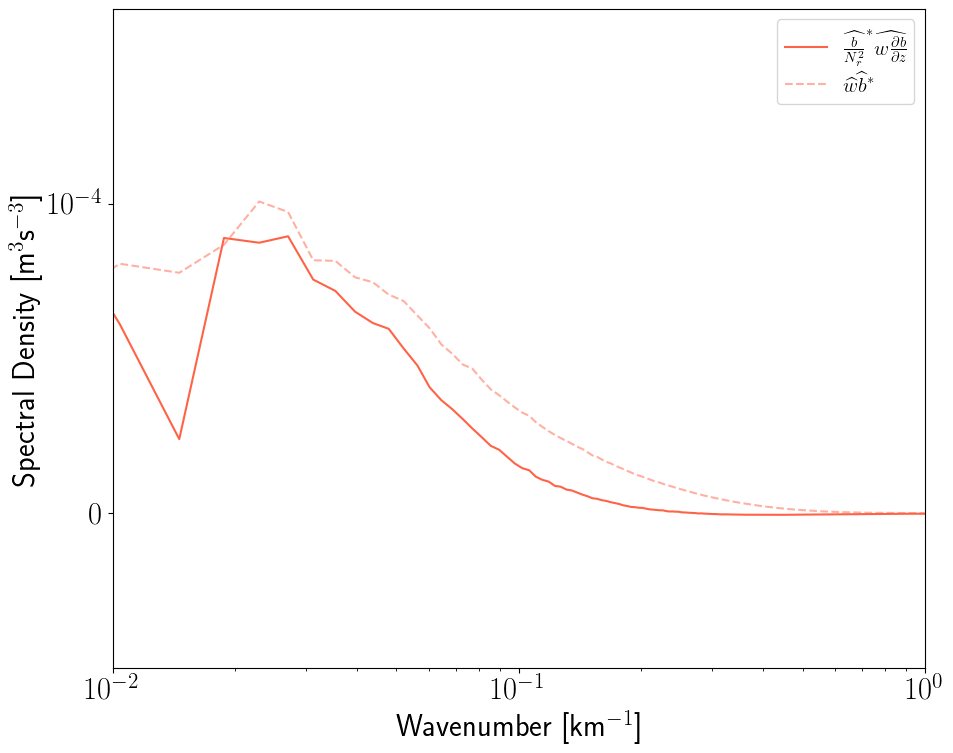

In [25]:
plt.figure(figsize=(10,8))
# plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_spec.mean(['ocean_time']).mean(['z_rho_psi'])/dxx*1e3,
#          color='red',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')



plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_full_tkN2[2:-8,:].mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
         color='tomato',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$') #N2 referenced inspace and time

# plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_full_spec2[:,2:-8,:].mean(['ocean_time']).mean(['z_rho'])/dxx*1e3, #N2 referenced in space only
#          color='tomato',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')

# plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_spec2[:,:,:].mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
#          color='green',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')

plt.plot(wb_spec.freq_r/dxx,(wb_spec).mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
         color='tomato',linestyle='--',label=r' $\widehat{w}\widehat{b}^*$',alpha=0.5)


plt.xscale('log')
plt.yscale('symlog', linthresh=1e-4)
plt.xlim(1e-2,1)
plt.ylim(-5e-5,5e-4)
plt.legend(fontsize=15)

plt.ylabel(r'Spectral Density [m$^{3}$s$^{-3}$]')
plt.xlabel(r'Wavenumber [km$^{-1}$]')
# plt.xlim(1//100,1)
# plt.ylim(-1e-2,1e-2)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_WB_B-N2WDBDZ_.png')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_WB_B-N2WDBDZ_finerZ.png')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_WB_B-N2WDBDZ_finerZ+N2refKandT.png')

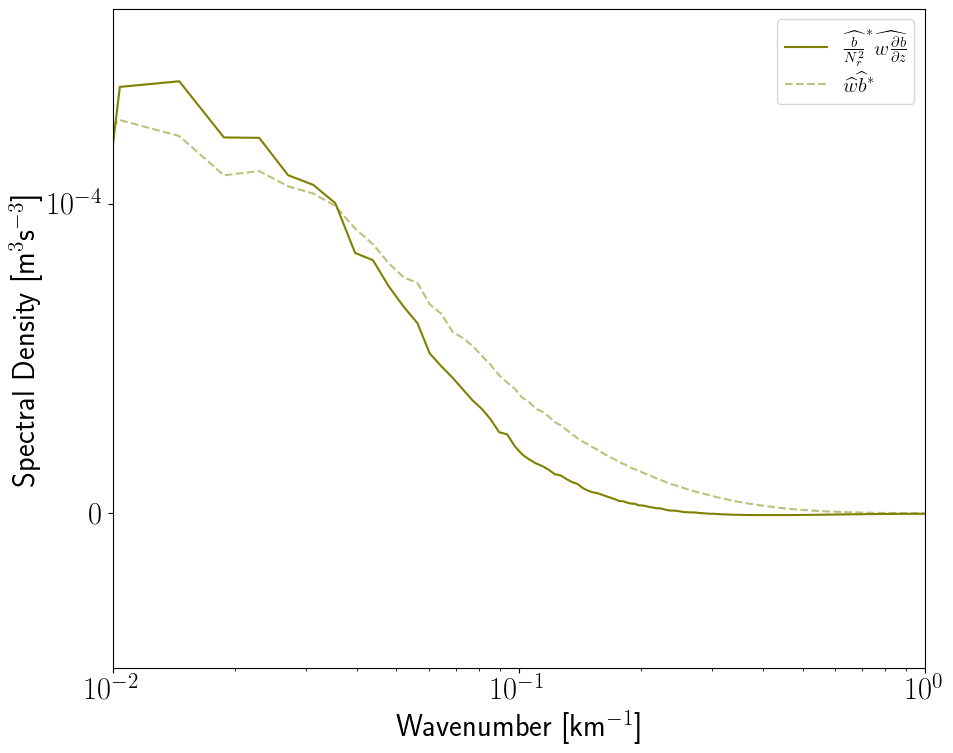

In [26]:

plt.figure(figsize=(10,8))
# plt.plot(wb_spec_smth.freq_r/dxx,bN2_w_dbdz_smth_spec.mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
#          color='olive',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')


plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_smth_tkN2[:,2:-8,:].mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
         color='olive',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$') #reference in space and time

# plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_smth_spec2[:,2:-8,:].mean(['ocean_time']).mean(['z_rho'])/dxx*1e3,
#          color='olive',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$') #reference in space


plt.plot(wb_spec_smth.freq_r/dxx,(wb_spec_smth).mean(['ocean_time']).mean(['z_rho_psi'])/dxx*1e3,
         color='olive',linestyle='--',label=r' $\widehat{w}\widehat{b}^*$',alpha=0.5)


plt.xscale('log')
plt.yscale('symlog', linthresh=1e-4)
plt.xlim(1e-2,1)
plt.ylim(-5e-5,5e-4)
plt.legend(fontsize=15)

plt.ylabel(r'Spectral Density [m$^{3}$s$^{-3}$]')
plt.xlabel(r'Wavenumber [km$^{-1}$]')
# plt.xlim(1//100,1)
# plt.ylim(-1e-2,1e-2)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_WB_B-N2WDBDZ_SMTH2.png')

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_WB_B-N2WDBDZ_SMTH2zfiner_N2refKandT.png')

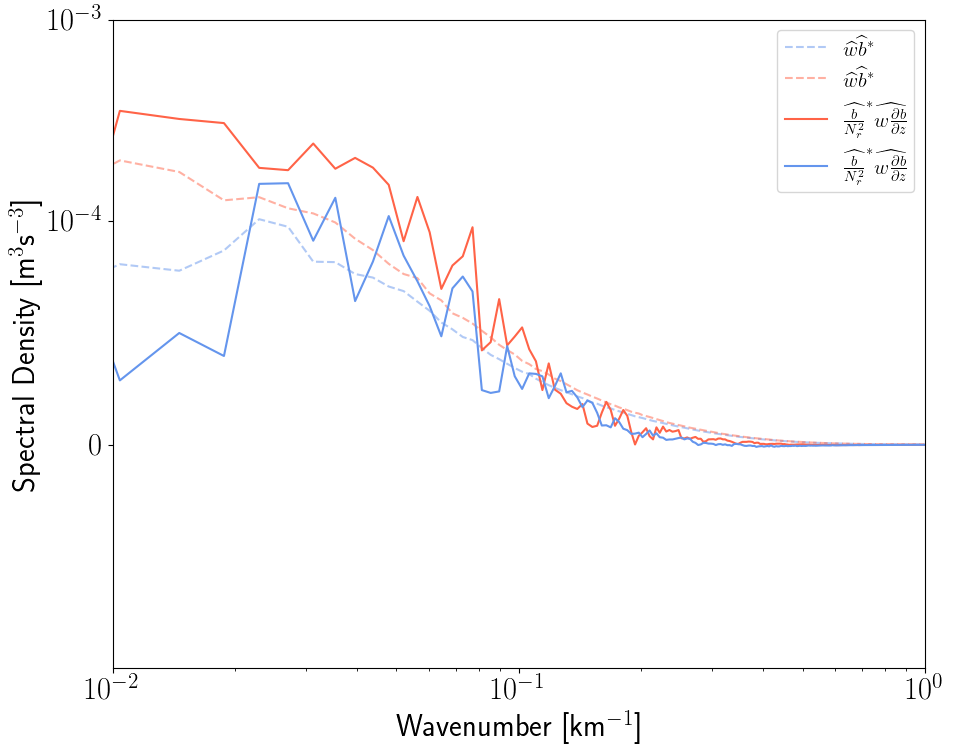

In [71]:
plt.figure(figsize=(10,8))

plt.plot(wb_spec.freq_r/dxx,(wb_spec_full).mean(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
         color='cornflowerblue',linestyle='--',label=r' $\widehat{w}\widehat{b}^*$',alpha=0.5)
plt.plot(wb_spec_smth.freq_r/dxx,(wb_spec_smth).mean(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
         color='tomato',linestyle='--',label=r' $\widehat{w}\widehat{b}^*$',alpha=0.5)


# plt.plot(wb_spec_smth.freq_r/dxx,bN2_w_dbdz_smth_spec2.sum(['z_rho']).mean(['ocean_time'])/dxx*1e3,
#          color='tomato',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')

# plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_spec2.sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
#          color='cornflowerblue',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')


plt.plot(wb_spec_smth.freq_r/dxx,bN2_w_dbdz_smth_spec2[:,2:-9,:].mean(['z_rho']).mean(['ocean_time'])/dxx*1e3,
         color='tomato',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')

plt.plot(wb_spec.freq_r/dxx,bN2_w_dbdz_full_spec2[:,2:-9,:].mean(['z_rho']).mean(['ocean_time'])/dxx*1e3,
         color='cornflowerblue',label=r'$\widehat{\frac{b}{N^2_r}}^* \widehat{w \frac{\partial b}{\partial z}}$')


plt.xscale('log')
plt.yscale('symlog', linthresh=1e-4)
# plt.yscale('log')

plt.xlim(1e-2,1)
plt.ylim(-1e-4,1e-3)
plt.legend(fontsize=15)

plt.ylabel(r'Spectral Density [m$^{3}$s$^{-3}$]')
plt.xlabel(r'Wavenumber [km$^{-1}$]')
# plt.xlim(1//100,1)
# plt.ylim(-1e-2,1e-2)
plt.tight_layout()

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_wb_bwdbdz_FULL_SMTH.png')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/tests/Spectral_test_wb_bwdbdz_FULL_SMTH_finerZ.png')

## Plot 1 -  $\widehat{w \frac{\partial b}{\partial z}}^2$ x  $\widehat{w}^2 N_r^4$

In [17]:
plt.figure()
plt.plot(w_dbdz_spec.freq_r/dxx,w_dbdz_spec.sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
         color='cornflowerblue',label=r'$\widehat{w \frac{\partial b}{\partial z}}^2$')
plt.plot(w_spec.freq_r/dxx,(N2z*w_spec).sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
         color='cornflowerblue',linestyle='--',label=r' $\widehat{w}^2 N_r^4$',alpha=0.5)

# plt.plot(w_spec.freq_r/dxx,(N2z.mean(['ocean_time'])*w_spec).sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,
#          color='cornflowerblue',linestyle='--',label=r' $\widehat{w}^2 N_r^4$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1)

plt.legend(fontsize=10)
# plt.xlim(1//100,1)
# plt.ylim(-1e-2,1e-2)

NameError: name 'w_dbdz_spec' is not defined

<Figure size 640x480 with 0 Axes>

# Plot 2 - 

(0.01, 1)

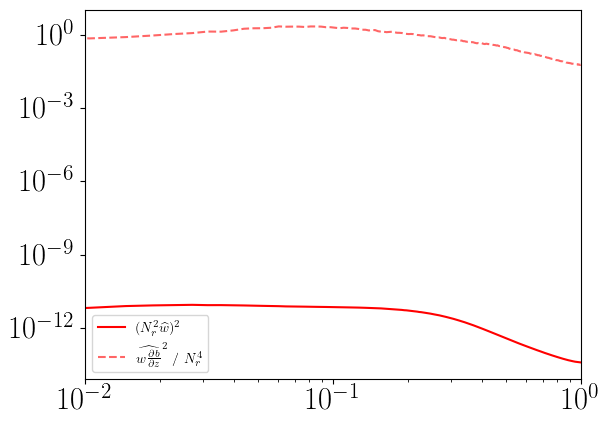

In [63]:
plt.figure()
plt.plot(w_spec.freq_r/dxx,w_spec.sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,color='red',label='$(N^2_r \widehat{w})^2$')

plt.plot(w_dbdz_spec.freq_r/dxx,(w_dbdz_spec/(N2z**2)).sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,color='red',
         label=r'$\widehat{w \frac{\partial b}{\partial z}}^2$ / $N^4_r$',linestyle='--',alpha=0.6)

# plt.plot(w_dbdz_spec.freq_r/dxx,(w_dbdz_spec/(N2z.mean(['ocean_time'])**2)).sum(['z_rho_psi']).mean(['ocean_time'])/dxx*1e3,color='red',
#          label=r'$\widehat{w \frac{\partial b}{\partial z}}^2$ / $N^4_r$',linestyle='--')



plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=10)

plt.xlim(1e-2,1)
# plt.ylim(-1e-2,1e-2)